
<font size = "5"> **Day 1: [Atomic Resolution STEM and Machine Learning](../MLSTEM2024.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

[Download](https://raw.githubusercontent.com/gduscher/MLSTEM2024//main/Day1/1_Aberrations.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MLSTEM2024/blob/main/Day1/1_Aberrations.ipynb)


# Aberration Correction 

part of the workshop of 

<font size = "5"> **[Machine Learning in Transmission Electron Microscopy](../_MLSTEM.ipynb)**</font>


**Day1: Atomic Resolution STEM,**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
    <td></td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**May 2025**

Main Contributer to Notebook: Utkarsh Pratish

## Import packages for figures and 
First we load the code to make figures from pyTEMlib
### Check Installed Packages


## Read aberrations - Run tableau

#### Contributor(s): Utkarsh Pratiush <utkarshp1161@gmail.com> - 6th May 2025
#### edited - 
   

We are using the jupyter kernel of python 3.10 for Autoscript compatibility

Please note that the AUtoscrip and CEOSacquisition is not freely available.


In [1]:
%matplotlib widget
import matplotlib.pylab as plt
import numpy  as np

import sys
sys.path.insert(0, "..//..//Autoscript//")
from autoscript_tem_microscope_client import TemMicroscopeClient
from autoscript_tem_microscope_client.enumerations import *
from autoscript_tem_microscope_client.structures import *
from autoscript_tem_microscope_client.structures import RunOptiStemSettings

sys.path.insert(0, "..//..//pyAutoMic//TEM//stemOrchestrator")
from stemOrchestrator.acquisition import CEOSAcquisitionTCP

%load_ext autoreload
%autoreload 2
sys.path.insert(0, "..//..//pyTEMlib//")
import pyTEMlib
import pyTEMlib.probe_tools
pyTEMlib.__version__


You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled


'0.2025.04.0'

## Connection to our microscope

We connect to 
- Autoscript
- CEOS SCORR server

In [3]:
ip = "10.46.217.241" 
port_ceos = 7072
port_TF = 9095

In [4]:
microscope = TemMicroscopeClient()
microscope.connect(ip, port=port_TF)
print("Connected to the microscope")

ceos_acquisition = CEOSAcquisitionTCP(host=ip, port=port_ceos)
print("Connected to CEOS SCORR on ", ceos_acquisition.host)

Client connecting to [10.46.217.241:9095]...
Client connected to [10.46.217.241:9095]
Connected to the microscope
Connected to CEOS SCORR on  10.46.217.241


## Check Vacuum

In [11]:
print("microscope vacumm is:",microscope.vacuum.state)
print("column valve is: ", microscope.vacuum.column_valves.state)

microscope vacumm is: Ready
column valve is:  Opened


### Open column valve
If everything is okay we can open the column valve

In [6]:
microscope.vacuum.column_valves.open()

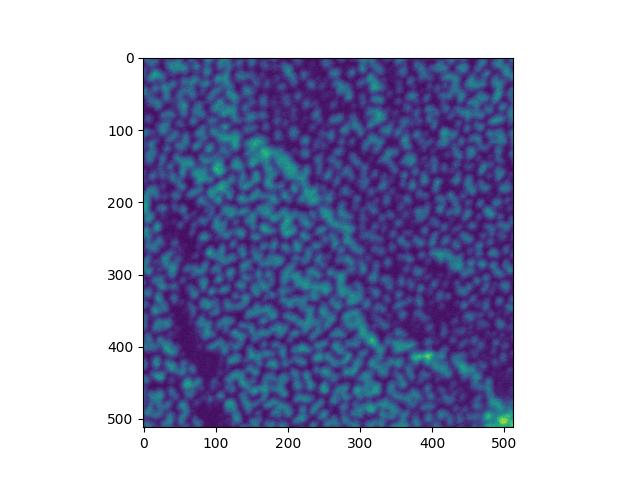

In [32]:
microscope.optics.defocus = 0e-9
microscope.optics.scan_field_of_view  = .17*1e-6
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 4e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data)

In [31]:
microscope.specimen.stage.relative_move([0,0, -0.1e-6])
microscope.specimen.stage.position*1e6


StagePosition(x=-0.021615, y=-0.005496, z=-82.99815, a=-3.136)

Here we are using the tableau function of the CEOS SCORR software.

- tabtype can be "Fast", "Standard", "Enhanced"
- angle is in mili-radian
- We want the first orders from this defocus=C1=C$_{1,0}$, astigmatismus A1,B2, A2

## 

In [36]:
microscope.optics.unblank()
microscope.optics.scan_field_of_view  = 372*1e-9

tableau_result_12 = ceos_acquisition.run_tableau(tab_type="Fast", angle=1)


for key in tableau_result_12['aberrations']:
    print(f" {key}: {np.linalg.norm(tableau_result_12['aberrations'][key])*1e9:.2f}nm ")

 A1: 9.21nm 
 A2: 22.38nm 
 B2: 19.71nm 
 C1: 7.18nm 
 WD: 1141342.18nm 


In [68]:
ceos_acquisition.correct_aberration("B2", value=tableau_result['aberrations']['B2'])

In [37]:
def correct_low_orders(aberrations):
    ceos_acquisition.correct_aberration("C1", value=aberrations['C1'])
    ceos_acquisition.correct_aberration("A1", value=aberrations['A1'])
    if np.linalg.norm(aberrations['A2']) >50e-9:
        ceos_acquisition.correct_aberration("A2", value=aberrations['A2'])
    if np.linalg.norm(aberrations['B2']) >50e-9:
        ceos_acquisition.correct_aberration("B2", value=aberrations['B2'])

correct_low_orders(tableau_result_12['aberrations'])

In [38]:
microscope.optics.scan_field_of_view  = 372*1e-9
microscope.optics.unblank()

tableau_result = ceos_acquisition.run_tableau(tab_type="Enhanced", angle=40)# use "Fast", "Standard", "Enhanced" --angle is in mili-radian 9,18,343
tableau_result


{'aberrations': {'A1': [-2.8578630015954834e-09, -2.4632975985657553e-09],
  'A2': [1.1235873338673051e-07, -3.7754284403273875e-08],
  'C3': [-7.685070782968027e-07, 0.0],
  'C1': [-3.291271535888972e-10, 0.0],
  'A4': [-1.3442881587411344e-06, -3.0118409679762645e-07],
  'A3': [-3.791618126665537e-08, -3.549769299169348e-09],
  'A5': [5.055369054216311e-06, -3.2838874898950555e-05],
  'B2': [-3.8947229849093095e-09, 2.6108773600889895e-09],
  'B4': [-9.935115438270635e-07, 2.214715334769184e-06],
  'S3': [2.582528101297615e-07, 2.6655233030464154e-07],
  'C5': [-1.2023104244237045e-05, 0.0],
  'D4': [9.546528802696526e-07, 4.077394546885951e-06],
  'WD': [0.0005891705755529291, 0.0011971131553597187]},
 'confidence': {'A1': 2.0842437829870717e-09,
  'A2': 3.982863149825164e-08,
  'C3': 1.184900714717484e-06,
  'C1': 1.4192442938353958e-09,
  'A4': 5.870306707426745e-06,
  'A3': 3.5376096434565235e-07,
  'A5': 0.00010273343740871688,
  'B2': 3.0455237926952905e-08,
  'B4': 6.624674945

In [ ]:
tableau_result

In [98]:
tableau_result['aberrations']['C3'][0]*=.5
tableau_result['aberrations']['C3'][1]*=.5
ceos_acquisition.correct_aberration("C3", value=tableau_result['aberrations']['C3'])

In [72]:
%load_ext autoreload
%autoreload 2
sys.path.insert(0, "..//..//..//..//..//pyTEMlib//")
import pyTEMlib
import pyTEMlib.probe_tools
pyTEMlib.__version__

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled


'0.2025.04.0'

In [ ]:
aberrations = pyTEMlib.probe_tools.ceos_carth_to_nion(tableau_result['aberrations'])
aberrations['Cc'] = 1e7
aberrations['acceleration_voltage'] = 200000
pyTEMlib.probe_tools.print_aberrations(aberrations)

In [77]:

tableau_result['aberrations']['B2']

[7.978664605888964e-09, -9.91532572669838e-09]

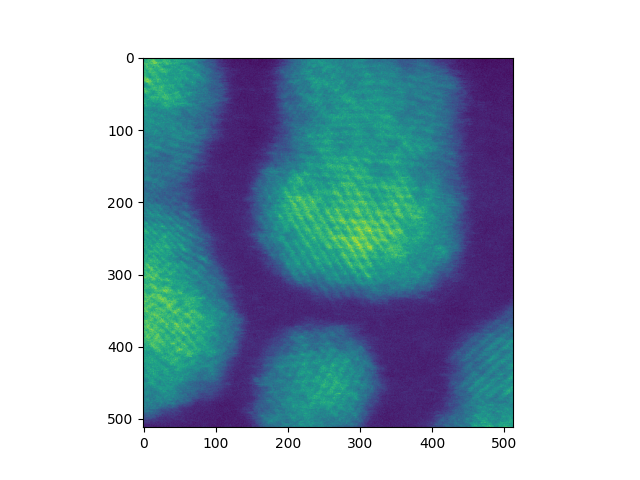

In [102]:
plt.close('all')
# microscope.optics.defocus = -27e-9
microscope.optics.scan_field_of_view  = 10*1e-9
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 16e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data)

In [48]:
ceos_acquisition.correct_aberration("C1", value=(2e-9, 0), select="fine")

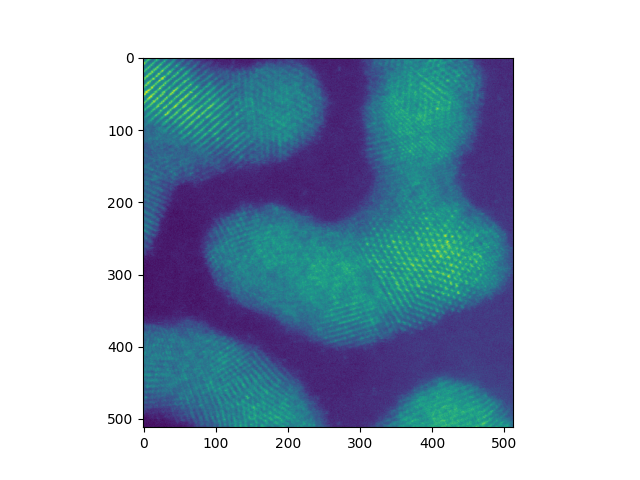

In [54]:
#microscope.optics.defocus = -39e-9
microscope.optics.scan_field_of_view  = 15*1e-9
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 16e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data)

In [41]:
microscope.optics.scan_field_of_view  = 25*1e-9

settings = RunOptiStemSettings(method=OptiStemMethod.C1_A1, dwell_time=2*1e-6, cutoff_in_pixels=5)
microscope.auto_functions.run_opti_stem(settings)

RunOptiStemResults(quality=Good)

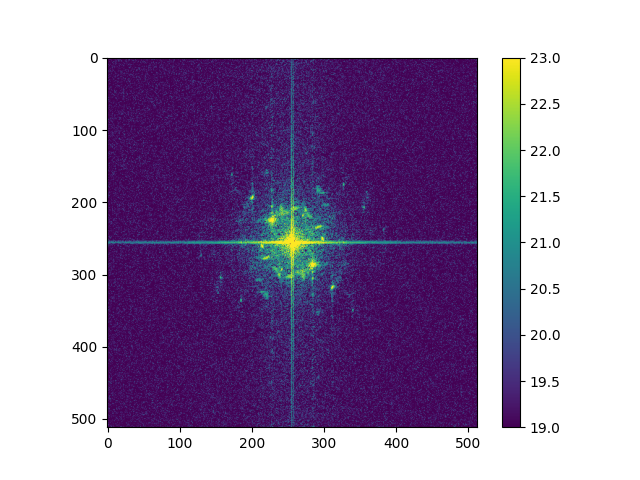

In [62]:
import numpy as np
fft_image = np.fft.fftshift(np.fft.fft2(haadf_image.data))

plt.figure()
plt.imshow(np.log2(1+np.abs(fft_image)), vmin=19, vmax=23)
plt.colorbar()



In [64]:
import sidpy

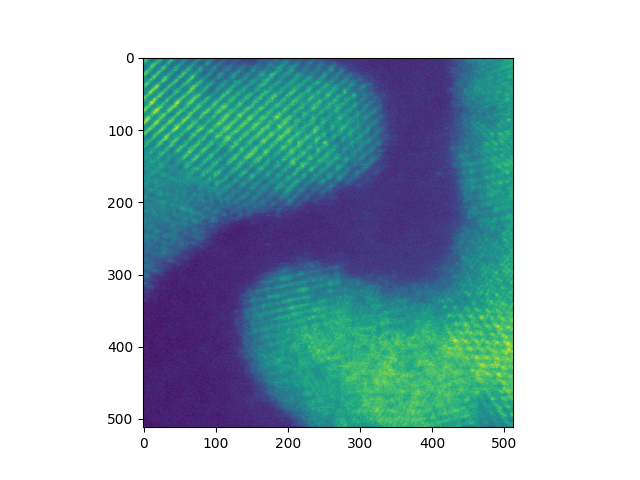

In [70]:
#microscope.optics.defocus = -39e-9
microscope.optics.scan_field_of_view  = 10*1e-9
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 16e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data)

In [69]:
for i in range(10):
    haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 4e-6)# haadf is pixel wise
    im.set_data(haadf_image.data)
    #fig.canvas.draw()     

    print(i)

0
1
2
3
4
5
6
7
8
9


In [79]:
dir(haadf_image.metadata)

['_Acquisition',
 '_BinaryResult',
 '_Core',
 '_CustomPropertyGroup',
 '_CustomSectionGroup',
 '_EnergyFilterSettings',
 '_GasInjectionSystems',
 '_Instrument',
 '_Labels',
 '_Optics',
 '_Sample',
 '_ScanSettings',
 '_StageSettings',
 '_StructureBase__repr_format_defaults',
 '_VacuumProperties',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_analytical_detectors',
 '_clear_items',
 '_construct_ineligible_value_error_message',
 '_deserialize',
 '_deserialize_from',
 '_generate_repr',
 '_get_item',
 '_has_item',
 '_has_raw_metadata_as_xml',
 '_imaging_detectors',
 '_init_in_progress',
 '_init_item',
 '_is_value_eligible',
 '_items',
 '_lazy_deserializati

In [98]:
dir(haadf_image.metadata.binary_result), haadf_image.metadata.binary_result.pixel_size_x_unit



(['_AcquisitionArea',
  '_AcquisitionUnit',
  '_BitsPerPixel',
  '_BlackLevel',
  '_CompositionType',
  '_Detector',
  '_DetectorIndex',
  '_DigitalBrightness',
  '_DigitalContrast',
  '_Encoding',
  '_FilterFrameCount',
  '_FilterType',
  '_Gamma',
  '_ImageSize',
  '_IntensityOffset',
  '_IntensityScale',
  '_IntensityScaleUnit',
  '_Offset',
  '_PixelSize',
  '_PixelSizeXUnit',
  '_PixelSizeYUnit',
  '_PixelValueMaximum',
  '_PixelValueMean',
  '_PixelValueMinimum',
  '_PixelValueStandardDeviation',
  '_RecursiveFilterCoefficient',
  '_ReferenceTransformation',
  '_Sharpness',
  '_SharpnessAlgorithm',
  '_Sigma',
  '_WhiteLevel',
  '__class__',
  '__delattr__',
  '__dict__',
  '__dir__',
  '__doc__',
  '__eq__',
  '__format__',
  '__ge__',
  '__getattribute__',
  '__gt__',
  '__hash__',
  '__init__',
  '__init_subclass__',
  '__le__',
  '__lt__',
  '__module__',
  '__ne__',
  '__new__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__setattr__',
  '__sizeof__',
  '__str__',
  

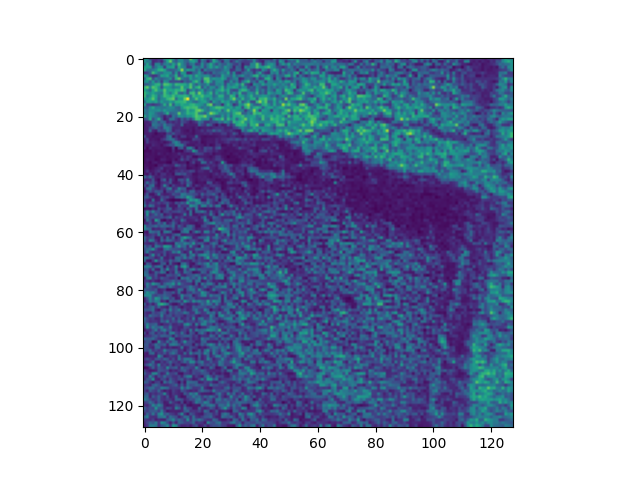

In [21]:
%matplotlib widget
import matplotlib.pylab as plt

fig = plt.figure()
im =  plt.imshow(haadf_image.data)

In [10]:
microscope.specimen.stage.absolute_move([0,0, 0])
print(microscope.specimen.stage.position*1e6)
microscope.vacuum.column_valves.close()

NameError: name 'pritn' is not defined

SyntaxError: '(' was never closed (445887163.py, line 1)